In [449]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = None

In [450]:
loan_data_defaults = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_defaults.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_15828\1491737682.py:1: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_defaults = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_defaults.csv')


# LGD Model

### Splitting the data

In [451]:
from sklearn.model_selection import train_test_split

In [452]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'CCF'], axis=1), loan_data_defaults['recovery_rate_0_1'], test_size=0.2, random_state=42)

### Preparing the inputs

In [453]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [454]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

### Stage 1 LGD, 0 or not 0 

In [455]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [456]:
lgd_inputs_stage_1_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,...,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim
19698,0,0,0,1,0,0,0,0,0,0,...,26.31,0.0,2.0,0.0,0.0,17.0,0.0,34.0,0.0,13700.0
26556,0,0,1,0,0,0,0,0,0,0,...,27.21,0.0,3.0,0.0,0.0,11.0,0.0,13.0,0.0,3000.0
21857,0,0,0,1,0,0,0,0,0,0,...,20.33,0.0,1.0,0.0,0.0,7.0,0.0,38.0,0.0,14600.0
9905,0,0,1,0,0,0,1,0,0,0,...,17.31,0.0,0.0,0.0,68.0,12.0,2.0,30.0,0.0,5800.0
9205,0,0,0,0,1,0,0,0,0,0,...,24.28,0.0,0.0,72.0,0.0,13.0,0.0,35.0,0.0,15900.0


In [457]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [458]:
reg_lgd_st_1 = LogisticRegression_with_p_values(max_iter=2000)
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

In [459]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [460]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-3.911325e-04,NaN
1,grade:A,-6.037488e-05,9.994371e-01
2,grade:B,-2.613631e-04,9.969795e-01
3,grade:C,-4.077053e-04,9.951105e-01
4,grade:D,4.145266e-05,9.995222e-01
5,grade:E,4.824820e-05,9.994957e-01
6,grade:F,2.125441e-04,9.980663e-01
7,home_ownership:MORTGAGE,-9.100704e-05,9.971613e-01
8,home_ownership:NONE,2.434872e-06,9.999976e-01
9,home_ownership:OTHER,-2.651816e-07,9.999995e-01


In [461]:
summary_table.to_csv(r'lgd_stage_1_logreg_summary_table.csv')

### Testing the model

In [462]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [463]:
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [464]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [465]:
# probability of recovery rate > 0
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[:][:, 1]

In [466]:
y_hat_test_proba_lgd_stage_1

array([0.5812717 , 0.62949774, 0.40447759, ..., 0.50229427, 0.58299081,
       0.44998428])

In [467]:
# https://gist.github.com/brentp/089c7d6d69d78d26437f
# https://www.statsmodels.org/dev/generated/statsmodels.othermod.betareg.BetaModel.html

In [468]:
lgd_targets_starge_1_test_temp = lgd_targets_stage_1_test

In [469]:
lgd_targets_starge_1_test_temp.reset_index(drop=True, inplace=True)

In [470]:
df_actual_predicted_probs = pd.concat([lgd_targets_starge_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis=1)
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [471]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
21362,1,0.581272
8768,1,0.629498
11903,0,0.404478
42973,1,0.554230
29933,0,0.422113


### Estimating the Accuracy of the Model

In [472]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [473]:
# confusion matrix
# actual values as rows, and predicted classes as columns

pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,1527,2235
1,1060,3826


In [474]:
# confusion matrix
# actual values as rows, and predicted classes as columns

pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames=['Actual'], colnames=['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.176573,0.258441
1,0.122572,0.442414


In [475]:
# accuracy of the model
# total correctly predicted / total number of observations
(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
           rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0,0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'],
           rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

0.6189870490286772

In [476]:
# receiver operating characteristic curve
# shows the accuracy at different cutoff thresholds
from sklearn.metrics import roc_curve, roc_auc_score

In [477]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

In [478]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

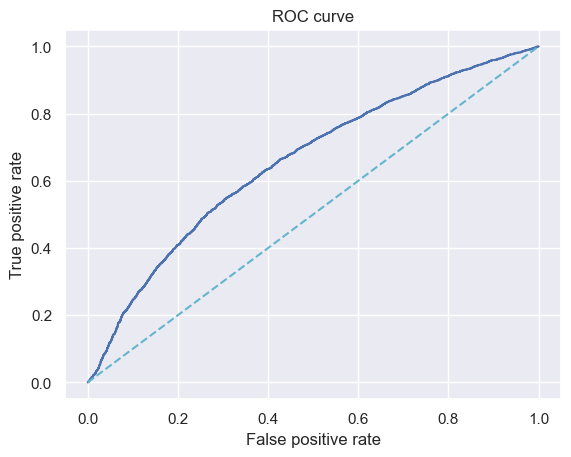

In [479]:
plt.plot(fpr, tpr) # ROC curve
plt.plot(fpr, fpr, linestyle= '--', color='c') # Benchmark 50/50
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [480]:
# area under the ROC curve is AUC is a good measure of how well the classification model is performing
# each point on the curve represents different confusion matrices with different cutoff thresholds
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.656936580402121

### Saving the model

In [481]:
import pickle

In [482]:
pickle.dump(reg_lgd_st_1, open('lgd_stage_1_model.sav', 'wb'))

### Stage 2 recovery rate for observations > 0

In [483]:
# not 0 : recovery_rate_0_1 = 1
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'CCF'], axis=1), lgd_stage_2_data['recovery_rate'], test_size=0.2, random_state=42)

In [484]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [485]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1, positive=False):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [486]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [487]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis=1)

In [488]:
# linear regression
lin_reg_st_2 = LinearRegression()
lin_reg_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

C:\WPy64-31101\python-3.11.0.amd64\Lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


LinearRegression()

In [489]:
feature_name = lgd_inputs_stage_2_train.columns.values

In [490]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(lin_reg_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', lin_reg_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = lin_reg_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.407060e-01,NaN
1,grade:A,-6.826469e-02,0.000000e+00
2,grade:B,-5.083300e-02,0.000000e+00
3,grade:C,-3.747936e-02,0.000000e+00
4,grade:D,-2.717280e-02,1.968647e-12
5,grade:E,-1.316041e-02,1.916923e-03
6,grade:F,-5.259127e-03,2.749616e-01
7,home_ownership:MORTGAGE,2.834188e-03,6.031935e-02
8,home_ownership:NONE,1.459157e-01,9.080237e-05
9,home_ownership:OTHER,-9.472643e-03,6.438076e-01


In [491]:
summary_table.to_csv(r'lgd_stage_2_linreg_summary_table.csv')

In [492]:
# each coefficient represents unit change in dependent variable
# if purpose:wedding, recovery rate 2.035% higher

In [493]:
# example using beta regression
from statsmodels.othermod.betareg import BetaModel
import statsmodels.api as sm

# generate some data
np.random.seed(42)
x1 = np.random.normal(size=100)
x2 = np.random.normal(size=100)
x3 = np.random.normal(size=100)
x4 = np.random.normal(size=100)
x5 = np.random.normal(size=100)

# the dependent variable
lgd = np.random.beta(2, 5, size=100)

# add a constant term to the independent variables
x = sm.add_constant(np.column_stack((x1, x2, x3, x4, x5)))

# fit the model
beta_model = BetaModel(lgd, x)
beta_results = beta_model.fit()

# we can get mean predictions and confidence intervals
# pred_results = beta_results.get_prediction(exog=new_x)
# pred_mean = pred_results.predicted_mean
# pred_conf_int = pred_results.conf_int()

# print summary of the model
print(beta_results.summary())

# get the p-values
p_values = beta_results.pvalues
p_values

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 52.416
Model:                      BetaModel   AIC:                            -90.83
Method:            Maximum Likelihood   BIC:                            -72.60
Date:                Fri, 27 Jan 2023                                         
Time:                        15:33:27                                         
No. Observations:                 100                                         
Df Residuals:                      93                                         
Df Model:                           6                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9432      0.077    -12.314      0.000      -1.093      -0.793
x1            -0.0710      0.084     -0.845      0.3

array([7.61296584e-35, 3.98058338e-01, 6.34012407e-01, 3.44599094e-01,
       8.80884595e-01, 9.20703479e-01, 2.57731212e-51])

In [494]:
# beta regression applied to stage 2 lgd
from statsmodels.othermod.betareg import BetaModel
import statsmodels.api as sm

# add a constant term to the independent variables
x = sm.add_constant(lgd_inputs_stage_2_train.values)

# setting targets = 1 to just less than
targets = lgd_targets_stage_2_train
targets = np.where(targets == 1, 1 - 1.e-6, targets)
targets = targets.reshape(-1,)

# fit the model
beta_model = BetaModel(targets, x)
beta_reg_st_2 = beta_model.fit(maxiter=2000, method='bfgs')

# print summary of the model
print(beta_reg_st_2.summary())

# get the p-values
# p_values = beta_results.pvalues

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 23439.
Model:                      BetaModel   AIC:                        -4.679e+04
Method:            Maximum Likelihood   BIC:                        -4.642e+04
Date:                Fri, 27 Jan 2023                                         
Time:                        15:33:30                                         
No. Observations:               19496                                         
Df Residuals:                   19450                                         
Df Model:                          45                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2435      0.148     -1.643      0.100      -0.534       0.047
x1            -0.4025      0.092     -4.377      0.0

C:\WPy64-31101\python-3.11.0.amd64\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [495]:
# to get new predictions 

# new_x = sm.add_constant(X)

# generate predictions
# predictions = beta_reg_st_2.predict(new_x)

In [496]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = beta_reg_st_2.params[1:-1]
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', beta_reg_st_2.params[0]]
summary_table = summary_table.sort_index()
p_values = beta_reg_st_2.pvalues[1:-1]
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.435267e-01,NaN
1,grade:A,-4.025329e-01,1.205939e-05
2,grade:B,-2.731173e-01,2.266770e-04
3,grade:C,-2.106494e-01,7.528971e-04
4,grade:D,-1.172368e-01,2.897177e-02
5,grade:E,-6.381306e-03,8.933196e-01
6,grade:F,-3.583375e-03,9.383283e-01
7,home_ownership:MORTGAGE,-4.453529e-03,7.420690e-01
8,home_ownership:NONE,2.445130e+00,1.998796e-25
9,home_ownership:OTHER,1.784769e-01,3.736549e-01


In [497]:
summary_table.to_csv(r'lgd_stage_2_betareg_summary_table.csv')

In [498]:
# for each coefficient, one unit increase in that variable = coefficient % higher recovery rate

### Model evaluation

In [499]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]

In [500]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis=1)

In [501]:
lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [502]:
# predictions for linear regression
y_hat_test_lgd_stage_2_linreg = lin_reg_st_2.predict(lgd_inputs_stage_2_test)

In [503]:
# predictions for beta regression
new_x = sm.add_constant(lgd_inputs_stage_2_test.values)

# generate predictions
y_hat_test_lgd_stage_2_betareg = beta_reg_st_2.predict(new_x)

In [504]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [505]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop=True)

In [506]:
# linear regression correlation
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2_linreg)], axis=1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.308012
0,0.308012,1.000000


In [507]:
# beta regression correlation
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2_betareg)], axis=1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.305862
0,0.305862,1.000000


C:\Users\User\AppData\Local\Temp\ipykernel_15828\2125684889.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2_linreg)


<AxesSubplot: xlabel='recovery_rate', ylabel='Density'>

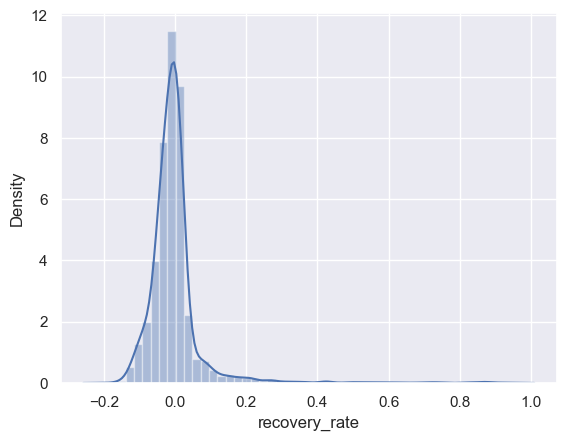

In [508]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2_linreg)

C:\Users\User\AppData\Local\Temp\ipykernel_15828\2142237640.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2_betareg)


<AxesSubplot: xlabel='recovery_rate', ylabel='Density'>

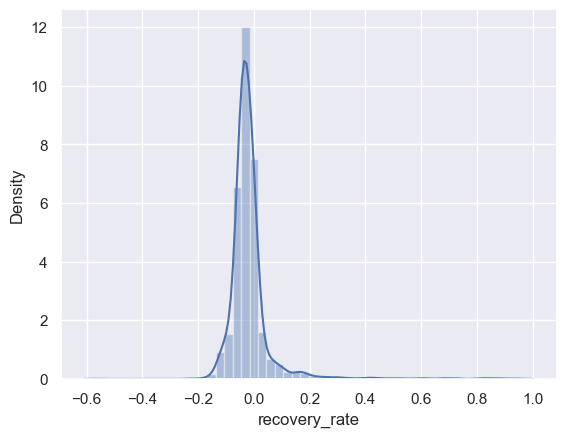

In [509]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2_betareg)

In [510]:
pickle.dump(beta_reg_st_2, open('lgd_stage_2_betareg_model.sav', 'wb'))
pickle.dump(lin_reg_st_2, open('lgd_stage_2_linreg_model.sav', 'wb'))

### Combining Stage 1 and Stage 2

### 1. Stage 1 = Is recovery rate 0 or not zero
### 2. If not zero move to stage 2, forecast non-zero recovery rate

In [511]:
y_hat_test_lgd_stage_2_all_linreg = lin_reg_st_2.predict(lgd_inputs_stage_1_test)

beta_X = sm.add_constant(lgd_inputs_stage_1_test.values)
y_hat_test_lgd_stage_2_all_betareg = beta_reg_st_2.predict(beta_X)

In [512]:
# we predict stage 2 model on all the inputs, then multiply by the predictions of stage 1 model
# this gives us recovery rate forecasts, multiplied by 1/0 depending on if no recovery is expected or some recovery
y_hat_test_lgd_linreg = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all_linreg
y_hat_test_lgd_betareg = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all_betareg

In [513]:
pd.DataFrame(y_hat_test_lgd_linreg).describe()

,0
count,8648.000000
mean,0.072813
std,0.052882
min,-0.007588
25%,0.000000
50%,0.090291
75%,0.115157
max,0.237010


In [514]:
pd.DataFrame(y_hat_test_lgd_betareg).describe()

,0
count,8648.000000
mean,0.082633
std,0.062528
min,0.000000
25%,0.000000
50%,0.096132
75%,0.131395
max,0.604422


In [516]:
# constrain linear regression model between 0 and 1
y_hat_test_lgd_linreg = np.where(y_hat_test_lgd_linreg < 0, 0, y_hat_test_lgd_linreg)
y_hat_test_lgd_linreg = np.where(y_hat_test_lgd_linreg > 1, 1, y_hat_test_lgd_linreg)